### Question 3

Using the Mauna Lua CO2 dataset (monthly) perform forecasting using an MLP and compare the results with that of MA (Moving Average) and ARMA (Auto Regressive Moving Average)  models. Main setting: use previous “K” readings to predict next “T” reading. Example, if “K=3” and “T=1” then we use data from Jan, Feb, March and then predict the reading for April. Comment on why you observe such results. For MA or ARMA you can use any library or implement it from scratch. The choice of MLP is up to you.

#### Import the Required Libraries and Functions

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import os
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Warning for future updates in pandas library
try:
    import pyarrow
except ImportError:
    %pip install pyarrow
import pandas as pd

try:
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
except ImportError:
    %pip install statsmodels
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper

In [30]:
def plot_compare_mlp(model, X_train, Y_train, scaler, K, T):
    Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1)).reshape(-1, T)

    Y_train_preds = scaler.inverse_transform(model.predict(X_train).reshape(-1, 1)).reshape(-1, T)
    train_loss = mean_squared_error(Y_train, Y_train_preds)

    # Plot the first component against the second component
    plt.scatter(Y_train[:, 0], Y_train[:, 1], label='True', s=5)
    plt.scatter(Y_train_preds[:, 0], Y_train_preds[:, 1], label='Predicted', s=5)
    plt.title(f'MLP Model on Dataset with K = {K} and T = {T}')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.legend()
    plt.text(0.95, 0.95, 'Loss: {:.2f}'.format(train_loss), horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

    plt.show()

In [31]:
def plot_compare_arma(model, Y_train, scaler, K, T):
    # Generate predictions
    Y_train_preds = np.empty_like(Y_train)
    for i in range(Y_train.shape[1]):
        model_i = model(Y_train[:, i], order=(1,0,1))
        model_i_fit = model_i.fit()
        Y_train_preds[:, i] = model_i_fit.predict(start=0, end=Y_train.shape[0]-1)

    # Inverse transform Y_train and Y_train_preds
    Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1)).reshape(-1, T)
    Y_train_preds = scaler.inverse_transform(Y_train_preds.reshape(-1, 1)).reshape(-1, T)

    # Calculate loss
    train_loss = mean_squared_error(Y_train, Y_train_preds)

    # Plot the first component against the second component
    plt.scatter(Y_train[:, 0], Y_train[:, 1], label='True', s=5)
    plt.scatter(Y_train_preds[:, 0], Y_train_preds[:, 1], label='Predicted', s=5)
    plt.title(f'ARMA Model on Dataset with K = {K} and T = {T}')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.legend()
    plt.text(0.95, 0.95, 'Loss: {:.2f}'.format(train_loss), horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

    plt.show()

In [32]:
def plot_compare_ma(model, Y_train, scaler, K, T):
    # Generate predictions
    Y_train_preds = np.empty_like(Y_train)
    for i in range(Y_train.shape[1]):
        model_i = model(Y_train[:, i], order=(0,0,1))  # MA model
        model_i_fit = model_i.fit()
        Y_train_preds[:, i] = model_i_fit.predict(start=0, end=Y_train.shape[0]-1)

    # Inverse transform Y_train and Y_train_preds
    Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1)).reshape(-1, T)
    Y_train_preds = scaler.inverse_transform(Y_train_preds.reshape(-1, 1)).reshape(-1, T)

    # Calculate loss
    train_loss = mean_squared_error(Y_train, Y_train_preds)

    # Plot the first component against the second component
    plt.scatter(Y_train[:, 0], Y_train[:, 1], label='True', s=5)
    plt.scatter(Y_train_preds[:, 0], Y_train_preds[:, 1], label='Predicted', s=5)
    plt.title(f'MA Model on Dataset with K = {K} and T = {T}')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.legend()
    plt.text(0.95, 0.95, 'Loss: {:.2f}'.format(train_loss), horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

    plt.show()

#### Loading and Processing the Given Mauna Lua CO2 Dataset

In [33]:
# Load the dataset
dataset = pd.read_csv('./co2_mm_mlo.csv', comment='#')

# Display the first 5 rows
print(dataset.head())

   year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0  1958      3     1958.2027   315.70          314.43     -1 -9.99 -0.99
1  1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2  1958      5     1958.3699   317.51          314.71     -1 -9.99 -0.99
3  1958      6     1958.4548   317.24          315.14     -1 -9.99 -0.99
4  1958      7     1958.5370   315.86          315.18     -1 -9.99 -0.99


In [34]:
# Data processing
dataset = dataset[['year', 'month', 'decimal date', 'average', 'deseasonalized']]

print(dataset.head(), end="\n\n")

# Normalize the dataset
scaler = StandardScaler()
dataset['average'] = scaler.fit_transform(dataset[['average']])

print(dataset.head())

   year  month  decimal date  average  deseasonalized
0  1958      3     1958.2027   315.70          314.43
1  1958      4     1958.2877   317.45          315.16
2  1958      5     1958.3699   317.51          314.71
3  1958      6     1958.4548   317.24          315.14
4  1958      7     1958.5370   315.86          315.18

   year  month  decimal date   average  deseasonalized
0  1958      3     1958.2027 -1.372166          314.43
1  1958      4     1958.2877 -1.316538          315.16
2  1958      5     1958.3699 -1.314631          314.71
3  1958      6     1958.4548 -1.323213          315.14
4  1958      7     1958.5370 -1.367080          315.18


In [35]:
# Initial parameters
K = 3
T = 2

# Preparing Train and Test dataset
X_train = np.array([dataset[['average']][i:(i+K)] for i in range(len(dataset)-(K+T)+1)]).reshape(-1, K)
Y_train = np.array([dataset[['average']][(i+K):(i+K+T)] for i in range(len(dataset)-(K+T)+1)]).reshape(-1, T)

# Display the train and test datasets
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")

X_train: (788, 3), Y_train: (788, 2)


In [36]:
mlp = MLPRegressor(hidden_layer_sizes=[256, 64, 32], max_iter=1, warm_start=True, random_state=42)

In [37]:
# Train the model for 10000 epochs, printing the loss every 1000 epochs
for i in range(2000):
    mlp.fit(X_train, Y_train)
    if (i+1) % 500 == 0:
        predictions = mlp.predict(X_train)
        loss = mean_squared_error(Y_train, predictions)
        print(f'Loss at epoch {i+1}: {loss}')

Loss at epoch 500: 0.0038392874170933467
Loss at epoch 1000: 0.0027299838836000534
Loss at epoch 1500: 0.002027076782645429
Loss at epoch 2000: 0.0029251625577466456


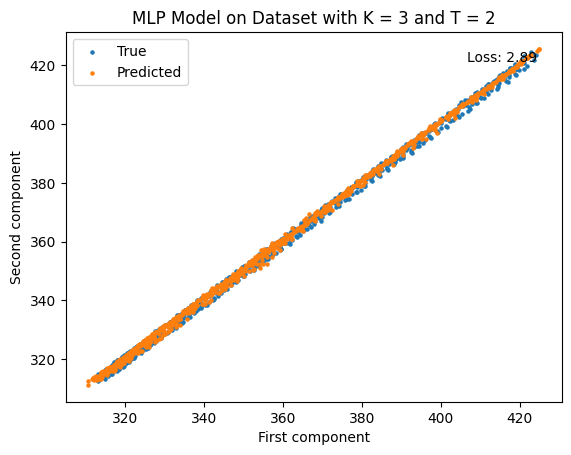

In [38]:
# Plot the datasets
plot_compare_mlp(mlp, X_train, Y_train, scaler, K, T)

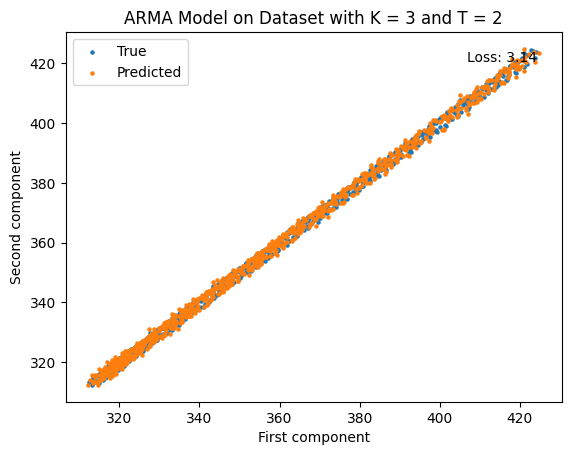

In [39]:
# Fit an ARMA model and plot the results
plot_compare_arma(ARIMA, Y_train, scaler, K, T)

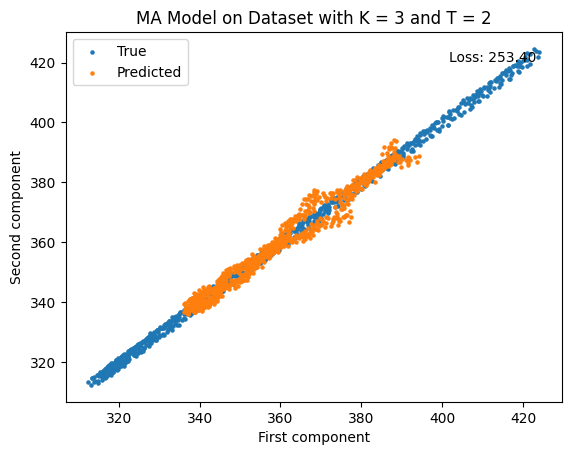

In [40]:
# Fit an MA model and plot the results
plot_compare_ma(ARIMA, Y_train, scaler, K, T)